# Scikit-learn analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


import untransformed data

In [2]:
from utils import read_data
df, X, y1, y2 = read_data("~/GitHub/3pt-shooting/data/preprocessed.csv")
display(df.head())

,POS,AGE,TEAM,G,GS,MP,FG,FGA,FG%,3P,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,next_3P%,3pt_dif
0,PG,31.0,ATL,80,80,2195,268,644,0.416,126,...,3.0,1.7,4.8,0.104,0.1,-0.2,-0.2,1.0,0.433825,0.044825
1,SG,29.0,ATL,79,0,2460,496,1105,0.449,163,...,5.6,1.7,7.3,0.143,3.5,-1.1,2.4,2.7,0.341000,-0.041000
2,SF,31.0,ATL,79,5,1317,175,393,0.445,57,...,2.1,1.1,3.1,0.114,-0.4,-0.6,-0.9,0.4,0.326041,-0.010959
3,SG,28.0,ATL,76,76,2886,635,1386,0.458,129,...,6.0,2.4,8.4,0.140,3.4,-0.7,2.7,3.4,0.297000,-0.072000
4,SF,23.0,ATL,81,81,2468,302,664,0.455,40,...,3.1,2.6,5.7,0.112,-0.4,0.1,-0.4,1.0,0.336000,0.033000


Program transformations and normalization

In [3]:
from sklearn.pipeline import Pipeline
from utils import pipeline
    
# ord_names = ['GS', 'SEASON']
preprocessor = pipeline(X)


split data into training and test sets, transform data, use y1 first

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, random_state=5)



try various linear regression algorithms

In [41]:
from sklearn.linear_model import LinearRegression
from utils import scores, model_train

lin = LinearRegression()

param_grid = {
    'model__fit_intercept': [False,True]
}

ln_reg = model_train(lin, X_train, y1_train, preprocessor=preprocessor, param_grid=param_grid)



rsquared:	0.272
Mean squared error:	0.001228
Mean absolute error:	0.0274


In [42]:
from sklearn.linear_model import Ridge

param_grid = {
    'model__alpha': np.logspace(-5,5, num=11, endpoint=5, base=10)
}

ridge = model_train(Ridge(), X_train, y1_train, preprocessor=preprocessor, param_grid=param_grid)


rsquared:	0.237
Mean squared error:	0.001286
Mean absolute error:	0.0280


These linear regressors perform very poorly

In [9]:
from sklearn.ensemble import RandomForestRegressor

# create parameter grid
param_grid = {
    'model__max_depth': [*list(np.linspace(1,3)), None]
}


tree = model_train(RandomForestRegressor(), X_train, y1_train, preprocessor=preprocessor, param_grid=param_grid)
print(scores(tree, X_test, y1_test))

rsquared:	0.883
Mean squared error:	0.000203
Mean absolute error:	0.0111
rsquared:	0.186
Mean squared error:	0.001443
Mean absolute error:	0.0293


Try baseline regressor, 

In [130]:
from sklearn.dummy import DummyRegressor

dummy = model_train(DummyRegressor(), X_train, y1_train, preprocessor=preprocessor)
print(scores(dummy, X_test, y1_test))


rsquared:	0.000
Mean squared error:	0.001686
Mean absolute error:	0.0319
rsquared:	-0.003
Mean squared error:	0.001934
Mean absolute error:	0.0345


## Fine Tuning Random Forest

In [118]:
from sklearn.model_selection import RandomizedSearchCV

X_train_scaled = preprocessor.fit_transform(X_train)

random_search = {'criterion': ['squared_error', 'absolute_error', 'poisson'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

reg = RandomForestRegressor()
model = RandomizedSearchCV(estimator = reg, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
# model.fit(X_train_scaled,y1_train)

Results: {'n_estimators': 151, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': None, 'criterion': 'squared_error'}

Summarize random search

In [12]:
print(model.best_params_)
print(model.best_score_)
print(model.score(X_train_scaled, y1_train))

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

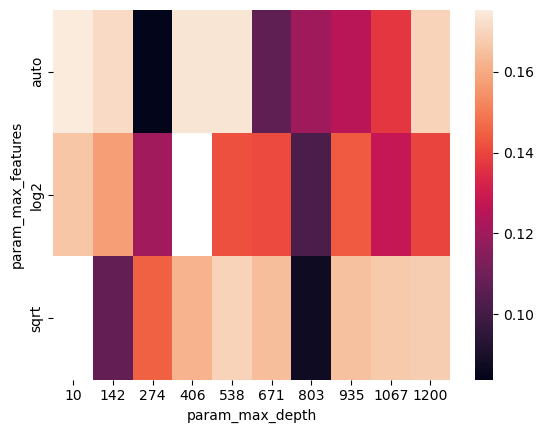

In [ ]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_max_features', 
                       columns='param_max_depth')
     
sns.heatmap(table)
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = {
    'criterion': [model.best_params_['criterion']],
    'max_depth': [model.best_params_['max_depth']],
    'max_features': [model.best_params_['max_features']],
    'min_samples_leaf': [model.best_params_['min_samples_leaf'] - 2, 
                         model.best_params_['min_samples_leaf'], 
                         model.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [model.best_params_['min_samples_split'] - 3, 
                          model.best_params_['min_samples_split'], 
                          model.best_params_['min_samples_split'] + 3],
    'n_estimators': [model.best_params_['n_estimators'] - 150, 
                     model.best_params_['n_estimators'] - 100, 
                     model.best_params_['n_estimators'], 
                     model.best_params_['n_estimators'] + 100, 
                     model.best_params_['n_estimators'] + 150]
}

model1 = GridSearchCV(estimator = reg, param_grid = grid_search,  
                               cv = 4, verbose= 5, n_jobs = -1)
model1.fit(X_train_scaled,y1_train)

Fitting 4 folds for each of 45 candidates, totalling 180 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [7, 10, 13],
                         'n_estimators': [1, 51, 151, 251, 301]},
             verbose=5)

In [ ]:
print(model1.best_params_)
print(model1.best_score_)
print(model1.score(X_train_scaled, y1_train))

{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 251}
0.17635111015500704
0.7120927456242697


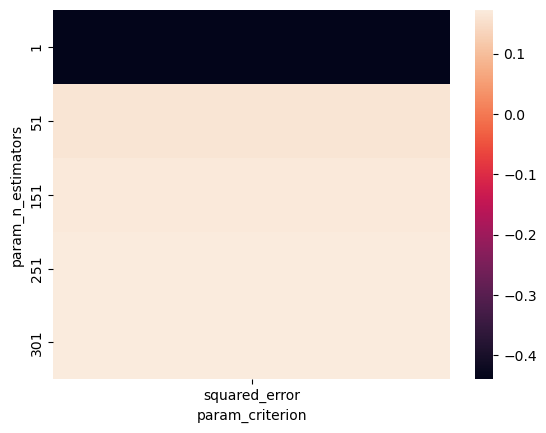

In [ ]:
table = pd.pivot_table(pd.DataFrame(model1.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)
plt.show()

In [ ]:
grid_search2 = {
    'criterion': [model1.best_params_['criterion']],
    'max_depth': [model1.best_params_['max_depth']],
    'max_features': [model1.best_params_['max_features']],
    'min_samples_leaf': [model1.best_params_['min_samples_leaf'] - 2, 
                         model1.best_params_['min_samples_leaf'] - 1, 
                         model1.best_params_['min_samples_leaf'], 
                         model1.best_params_['min_samples_leaf'] + 1,
                         model1.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [model1.best_params_['min_samples_split'] - 3, 
                          model1.best_params_['min_samples_split'], 
                          model1.best_params_['min_samples_split'] + 3],
    'n_estimators': [model1.best_params_['n_estimators'] - 100, 
                     model1.best_params_['n_estimators'] - 50, 
                     model1.best_params_['n_estimators'], 
                     model1.best_params_['n_estimators'] + 50, 
                     model1.best_params_['n_estimators'] + 100]
}
model2 = GridSearchCV(estimator = reg, param_grid = grid_search2,  
                               cv = 4, verbose= 5, n_jobs = -1)
model2.fit(X_train_scaled,y1_train)


Fitting 4 folds for each of 75 candidates, totalling 300 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [6, 7, 8, 9, 10],
                         'min_samples_split': [4, 7, 10],
                         'n_estimators': [151, 201, 251, 301, 351]},
             verbose=5)

In [ ]:
print(model2.best_params_)
print(model2.best_score_)
print(model2.score(X_train_scaled, y1_train))

{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 201}
0.17826535033036173
0.7109533380170536


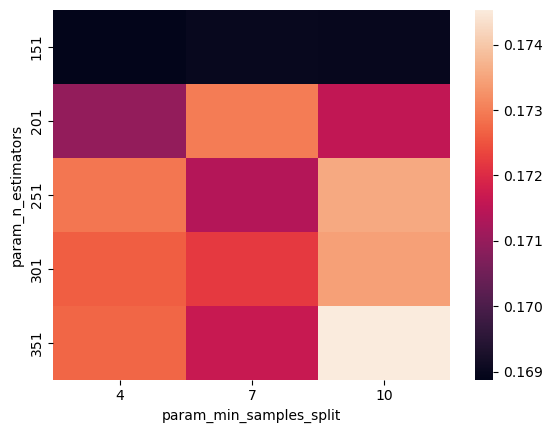

In [ ]:
table = pd.pivot_table(pd.DataFrame(model2.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_min_samples_split')
     
sns.heatmap(table)
plt.show()

In [ ]:
# grid_search3 = {
#     'criterion': [ 'squared_error' ],
#     'max_depth': [ None ],
#     'max_features': [ 'auto' ],
#     'min_samples_leaf': [8, 9, 10],
#     'min_samples_split': [ 8, 9, 10, 11],
#     'n_estimators': list(np.linspace(200, 400, 10, dtype = int))
# }
# model3 = GridSearchCV(estimator = reg, param_grid = grid_search2,  
#                                cv = 4, verbose= 5, n_jobs = -1)
# model3.fit(X_train_scaled,y1_train)

Fitting 4 folds for each of 75 candidates, totalling 300 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [6, 7, 8, 9, 10],
                         'min_samples_split': [4, 7, 10],
                         'n_estimators': [151, 201, 251, 301, 351]},
             verbose=5)

In [80]:
reg = RandomForestRegressor(**model2.best_params_)
tree1 = model_train(reg, X_train, y1_train, preprocessor=preprocessor)

print(scores(tree1, X_test, y1_test))

rsquared:	0.708
Mean squared error:	0.000508
Mean absolute error:	0.0169
rsquared:	0.189
Mean squared error:	0.001439
Mean absolute error:	0.0292


## Ridge Regression Parameter Tuning

In [119]:

ridge_search = {
    'alpha':np.logspace(-5, 5),
    'fit_intercept': [ True, False ],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

model = RandomizedSearchCV(estimator = Ridge(), param_distributions = ridge_search, n_iter = 80, 
                               cv = 4, random_state= 101)
model.fit(X_train_scaled,y1_train)

RandomizedSearchCV(cv=4, estimator=Ridge(), n_iter=80,
                   param_distributions={'alpha': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705...
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
                                        'fit_intercept': [True, False],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                        

In [120]:
print(model.best_params_)
print(model.best_score_)
print(model.score(X_train_scaled, y1_train))

{'solver': 'sag', 'fit_intercept': True, 'alpha': 138.9495494373139}
0.18936991122644986
0.23318723069802205


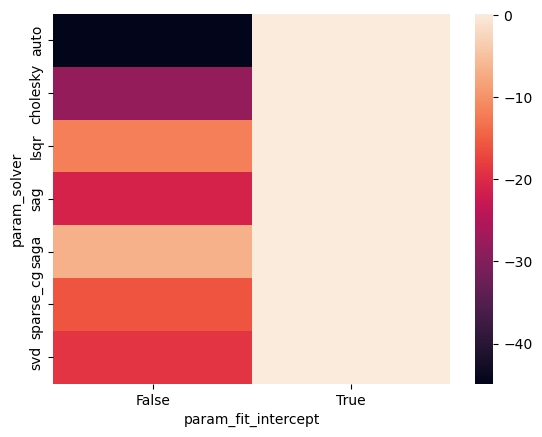

In [121]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_solver', 
                       columns='param_fit_intercept')
     
sns.heatmap(table)
plt.show()

In [122]:
from sklearn.model_selection import GridSearchCV

ridge_search2 = {
    'alpha':np.logspace(-1, 3, 20),
    'fit_intercept': [ True ],
    'solver': ['sag', 'saga']
}

model1 = GridSearchCV(estimator = Ridge(), param_grid = ridge_search2,cv = 4)
model1.fit(X_train_scaled,y1_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-01, 1.62377674e-01, 2.63665090e-01, 4.28133240e-01,
       6.95192796e-01, 1.12883789e+00, 1.83298071e+00, 2.97635144e+00,
       4.83293024e+00, 7.84759970e+00, 1.27427499e+01, 2.06913808e+01,
       3.35981829e+01, 5.45559478e+01, 8.85866790e+01, 1.43844989e+02,
       2.33572147e+02, 3.79269019e+02, 6.15848211e+02, 1.00000000e+03]),
                         'fit_intercept': [True], 'solver': ['sag', 'saga']})

In [123]:
print(model1.best_params_)
print(model1.best_score_)
print(model1.score(X_train_scaled, y1_train))

{'alpha': 233.57214690901213, 'fit_intercept': True, 'solver': 'sag'}
0.19005803348974712
0.22736099796153975


In [124]:
reg = Ridge(**model1.best_params_)
ridge = model_train(reg, X_train, y1_train, preprocessor=preprocessor)

print(scores(ridge, X_test, y1_test))

rsquared:	0.227
Mean squared error:	0.001303
Mean absolute error:	0.0281
rsquared:	0.176
Mean squared error:	0.001589
Mean absolute error:	0.0318


## Feature importance

In [103]:
feature_names = list()
feature_names.extend(ridge.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out())
feature_names.extend(ridge.named_steps['preprocessor'].transformers_[1][1].named_steps['scaler'].get_feature_names_out())

AttributeError: 'GridSearchCV' object has no attribute 'named_steps'

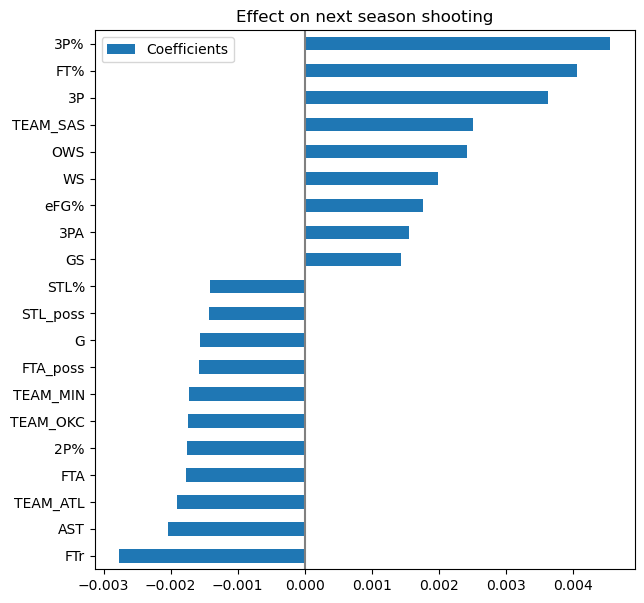

In [126]:
coefs = pd.DataFrame(
    ridge.named_steps['model'].coef_,
    columns=['Coefficients'], index=feature_names
)

coefs['signs'] = np.sign(coefs.Coefficients)
coefs['abs'] = np.abs(coefs.Coefficients)

coefs = coefs.sort_values(by=['abs'], ascending=False)

coefs_20 = coefs.iloc[0:20,:].sort_values(by=['Coefficients'])

coefs_20.plot(y='Coefficients',kind='barh', figsize=(9, 7))
plt.title('Effect on next season shooting')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()

## Feature reduction
Let's see how only using the most important features affects model performance.

In [127]:
coefs_20.index

Index(['FTr', 'AST', 'TEAM_ATL', 'FTA', '2P%', 'TEAM_OKC', 'TEAM_MIN',
       'FTA_poss', 'G', 'STL_poss', 'STL%', 'GS', '3PA', 'eFG%', 'WS', 'OWS',
       'TEAM_SAS', '3P', 'FT%', '3P%'],
      dtype='object')

In [135]:
from utils import scores

subset = ['FTr', 'AST', 'FTA', '2P%',
       'FTA_poss', 'G', 'STL_poss', 'STL%', 'GS', '3PA', 'eFG%', 'WS', 'OWS',
       'TEAM', '3P', 'FT%', '3P%']

# subset = ['FT%', '3P%','FTr','3P','G']

pct = X[subset]


lin = Ridge()

x_train, x_test, y_train, y_test = train_test_split(pct, y1, random_state=4)

pipe = pipeline(pct)

# x_train_scaled = pipe.fit_transform(x_train)

# lin.fit(x_train_scaled, y_train)

model = model_train(lin, x_train, y_train, preprocessor=pipe)
print(scores(model, x_test, y_test))
# pct.select_dtypes(include=['object', 'bool']).columns

# pipe

rsquared:	0.238
Mean squared error:	0.001305
Mean absolute error:	0.0284
rsquared:	0.167
Mean squared error:	0.001540
Mean absolute error:	0.0308


## RERF

In [43]:
from sklearn.ensemble import RandomForestRegressor


resid = ridge.predict(X_train) - y1_train

rfg = RandomForestRegressor()

resid = np.array(resid).reshape(-1,1)

rfg.fit(resid, y1_train)
rfg.score(resid, y1_train)




0.8120455686230533

In [44]:
resid_test = ridge.predict(X_test) - y1_test
resid_test = np.array(resid_test).reshape(-1,1)

rfg.score(resid_test, y1_test)

print(scores(rfg, resid_test, y1_test))

rsquared:	0.779
Mean squared error:	0.000426
Mean absolute error:	0.0158


In [46]:
from sklearn.ensemble import GradientBoostingRegressor

tree = model_train(GradientBoostingRegressor(), X_train, y1_train, preprocessor=preprocessor, param_grid=param_grid)
print(scores(tree, X_test, y1_test))

/home/fordfishman/anaconda3/envs/3pt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 55.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fordfishman/anaconda3/envs/3pt/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fordfishman/anaconda3/envs/3pt/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/fordfishman/anaconda3/envs/3pt/lib/python3.7/site-packages/sklearn/ensemble/_gb.

rsquared:	0.583
Mean squared error:	0.000704
Mean absolute error:	0.0210
rsquared:	0.128
Mean squared error:	0.001682
Mean absolute error:	0.0322


In [136]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

lasso = model_train(Lasso(), X_train, y1_train, preprocessor=preprocessor, param_grid=param_grid)

print(scores(lasso, X_test, y1_test))

X_p = lasso.predict(X_train)
resid = y1_train - X_p  

# X_train2 = X_train.assign(resid = resid)
# resid = pd.DataFrame({'resid':resid, '3pt':X_train['3P%']})
# resid = pd.DataFrame({'resid':resid})

rf = Ridge()

# rf.fit(resid, y1_train)
rf = model_train(Ridge(), X_train, resid, preprocessor=pipeline(X_train))


X_p_test = lasso.predict(X_test) + rf.predict(X_test)
resid_test = y1_test - X_p_test
# resid_test = np.array(resid_test).reshape(-1,1)
# X_test2 = X_test.assign(resid=resid_test)
# resid_test = pd.DataFrame({'resid':resid_test, '3pt':X_test['3P%']})

# print(scores(rf, X_test2, y1_test))

# pearsonr(X_p_test, y1_test)[0]**2
mean_squared_error(X_p_test, y1_test)


rsquared:	0.209
Mean squared error:	0.001333
Mean absolute error:	0.0285
rsquared:	0.173
Mean squared error:	0.001596
Mean absolute error:	0.0317
rsquared:	0.071
Mean squared error:	0.001238
Mean absolute error:	0.0275


0.0016102717326332255

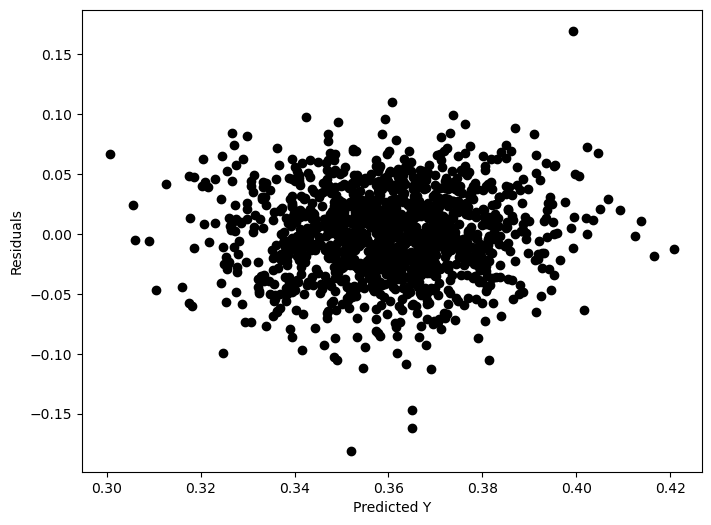

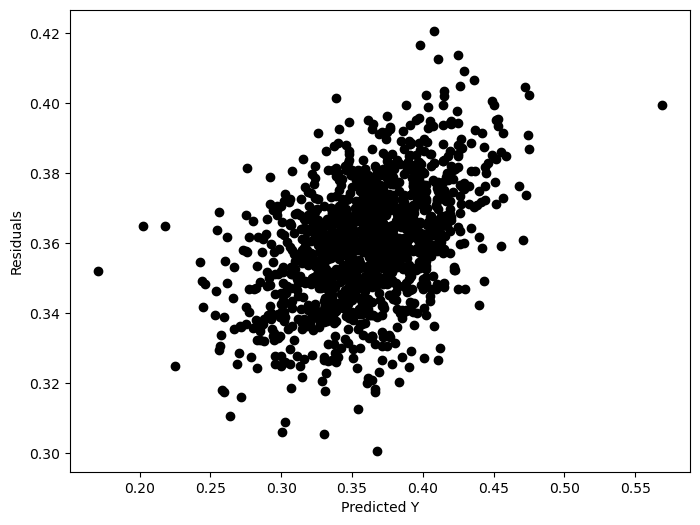

In [132]:
from utils import resid_plot

resid_plot(lasso, X_train, y1_train)
from scipy.stats import pearsonr

pearsonr(resid, X_p)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(y=X_p, x=y1_train,  color='black')
ax.set_xlabel('Predicted Y')
ax.set_ylabel('Residuals')
plt.show()

In [117]:
feature_names = list()
feature_names.extend(rf.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out())
feature_names.extend(rf.named_steps['preprocessor'].transformers_[1][1].named_steps['scaler'].get_feature_names_out())

AttributeError: 'Pipeline' object has no attribute 'transformers_'

Coefficients   -1.844886
signs          -1.000000
abs             1.844886
Name: TEAM_MEM, dtype: float64

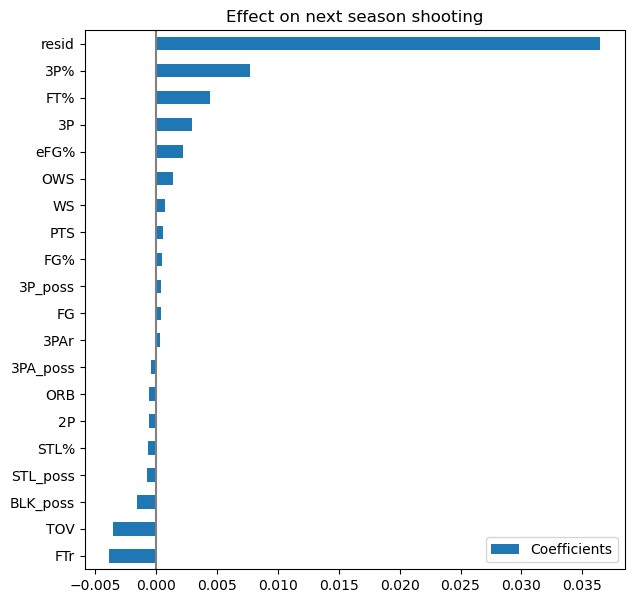

In [115]:
coefs = pd.DataFrame(
    rf.named_steps['model'].coef_,
    columns=['Coefficients'], index=feature_names
)

coefs['signs'] = np.sign(coefs.Coefficients)
coefs['abs'] = np.abs(coefs.Coefficients)

coefs = coefs.sort_values(by=['abs'], ascending=False)

coefs_20 = coefs.iloc[0:20,:].sort_values(by=['Coefficients'])

coefs_20.plot(y='Coefficients',kind='barh', figsize=(9, 7))
plt.title('Effect on next season shooting')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()